# Machine learning program for determining if a person has diabetes or not.
## Project information
The goal of this program is to determine if a person has type 2 diabetes or if he does  
does not have type 2 diabetes. To help us do this we will use a regression dataset,  
which contains 442 people, and each person has these 10 features:  
- Age
- Sex
- BMI
- Blood pressure
- Six blood serum measurement

Each of these 10 features is used as an indicator for type 2 diabetes progression  
after one year. If the progression identifier is above 140, it means that a person  
is going to get type 2 diabetes.

## Loading of libaries
For this program i use different libraries such as:
- Numpy
- Matplotlib
- Sklearn
- Tensorflow
- Keras
- Pandas

In [69]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix   
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

from sklearn.datasets import load_digits
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from tensorflow.keras.utils import plot_model
from keras.optimizers import SGD
import pandas as pd
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.cluster import KMeans

# Loading of dataset
The diabetes dataset we are using is a regression dataset from sklearn.  
The variabel "x" represents each person and their 10 features.  
The variabel "y" represents each person's type 2 diabetes progression after 1 year. 

In [83]:
data = load_diabetes()
x, y = data['data'], data['target']
print('Features of people:',data["feature_names"])
print('Amount of people and their features:',x.shape)
print('Number of people with diabetes progression:', y.shape)

Feature name: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
Amount of people and their features: (442, 10)
Number of people with diabetes progression: (442,)


In [71]:
x_train_normal, x_test_normal, y_train_normal, y_test_normal = train_test_split(x, y, test_size=0.2, random_state=42)

# Since the diabetes dataset is loaded as a regression dataset,
# we have to convert it to a classification problem.

# First we create an array of zeros with the same size as "y"
# Then we set each element to 1 in our "y_" array, where in the "y" array
# the correspoding element is bigger than 140. Then we convert the values
# of decimals in "y_" to integers.
y_ = np.zeros(y.shape)
y_[y > 140] = 1.
y_ = y_.astype(int)

# Then we split our data into 80% training data and 20% testing data
# The "random_state" parameter is used for reprodruction of the data. 
# The stratify parameter makes sure that "y_" is equally represented 
# in both training and test. This type of setup is called holdout.
x_train_labeled, x_test_labeled, y_train_labaled, y_test_labaled = train_test_split(x, y_, test_size=0.2, random_state=42, stratify=y_)

In [72]:
# Standardise the data so that all the data has a range between 0 and 1, 
# instead of between -1 and 1. This is to scale our features correctly.
min_max_scaler = MinMaxScaler(feature_range=(0,1))
x_train_standarized_labeled = min_max_scaler.fit_transform(x_train_labeled)
x_test_standarized_labeled = min_max_scaler.fit_transform(x_test_labeled)

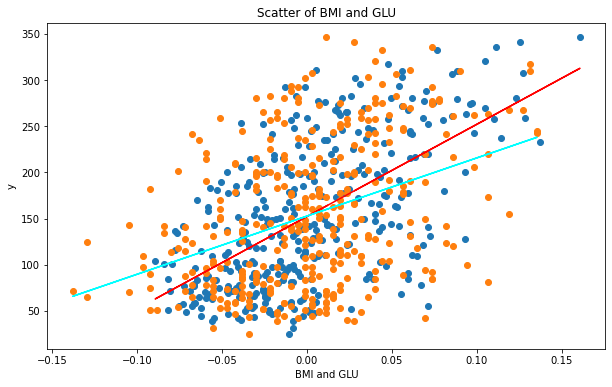

In [73]:
bmi = x_train_normal[:, np.newaxis, 2]
glu = x_train_normal[:, np.newaxis, 9]

y = y_train_normal[:, np.newaxis]

bmi_linear_regression = LinearRegression().fit(bmi, y_train_normal)
bmi_predicted_y = bmi_linear_regression.predict(bmi)

glu_linear_regression = LinearRegression().fit(glu, y_train_normal)
glu_predicted_y = glu_linear_regression.predict(glu)

# Plotting of the regression line on a scatterd plot
plt.figure(figsize=(10,6))
plt.scatter(bmi, y_train_normal)
plt.scatter(glu, y_train_normal)
plt.plot(bmi, bmi_predicted_y, c='r')
plt.plot(glu, glu_predicted_y, c='cyan')
plt.title('Scatter of BMI and GLU')
plt.ylabel('y')
plt.xlabel('BMI and GLU')
plt.show()

In [74]:
def select_features(train_data, y_data, test_data, n_features='all', regression=True):
    score_function = f_regression
    if (regression):
        score_function = chi2

    k_best = SelectKBest(score_func=score_function, k=n_features)
    k_best.fit(train_data, y_data)
    
    x_train_k_best = k_best.transform(train_data)
    x_test_k_best = k_best.transform(test_data)

    return x_train_k_best, x_test_k_best, k_best

def plot_k_best_score(scores):
    plt.bar([i for i in range(len(scores))], scores)
    plt.title('Score value of each feature')
    plt.xlabel('Feature')
    plt.ylabel('Score')
    plt.show()

def pca_features(dataset, transform, n_features=5):
    pca = PCA(n_components=n_features).fit(dataset)

    transformed = pca.transform(transform)

    return transformed, pca

def plot_pca_variance(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.title('PCA coverage features')
    plt.xlabel('Features')
    plt.ylabel('Coverage')
    plt.show()

def print_percent_correct(predicted, test):
    print('Percentage correct:', 100*np.sum(predicted == test) / len(test))

def plot_matrix(title, matrix):
    cmap = ListedColormap(['darkorange', 'gold', 'blue', 'red'])

    plt.figure()
    plt.matshow(matrix)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            plt.text(x=j, y=i, s=matrix[i,j], va='center', ha='center')
    
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

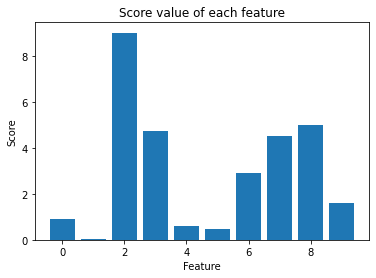

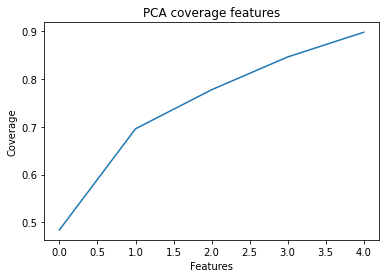

In [75]:
features = 5

x_trainset_features = x_train_standarized_labeled
y_trainset_features = y_train_labaled
x_testset_features = x_test_standarized_labeled

x_train_k_best, x_test_k_best, k_best = select_features(x_trainset_features, y_trainset_features, x_testset_features, n_features=features)
plot_k_best_score(k_best.scores_)

transformed, pca = pca_features(dataset=x_trainset_features, transform=x_trainset_features, n_features=features)
x_train_pca = transformed
transformed, pca = pca_features(dataset=x_trainset_features, transform=x_testset_features, n_features=features)
x_test_pca = transformed
plot_pca_variance(pca)

# VERY IMPORTANT! SET TRAINING DATA HERE!
x_train = x_train_k_best
x_test = x_test_k_best
y_train = y_train_labaled
y_test = y_test_labaled

<Figure size 432x288 with 0 Axes>

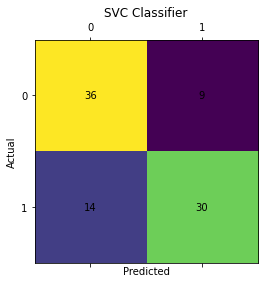

Percentage correct: 74.15730337078652


<Figure size 432x288 with 0 Axes>

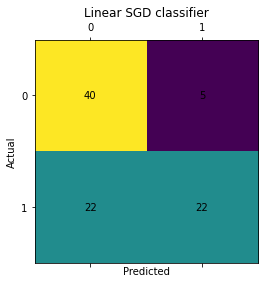

Percentage correct: 69.66292134831461


In [76]:
predicter = Sequential()

predicter.add(Dense(units=features*2, activation='relu', input_dim=features, name='Input'))
predicter.add(Dense(units=10, activation='relu', name='Hidden1'))
predicter.add(Dense(units=5, activation='relu', name='Hidden2'))
predicter.add(Dense(units=1, activation='sigmoid', name='Output'))

predicter.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

svc_clf = SVC(random_state=42,kernel='rbf', C=2200, gamma=0.0001)
svc_clf.fit(x_train, y_train)
y_pred_svc = svc_clf.predict(x_test)
svc_clf.get_params

# Confusion matrix SVC
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_svc)
plot_matrix('SVC Classifier', cm)
print_percent_correct(y_pred_svc, y_test)

# Linear SDG classifier using SVM(Support venctor machine)
sgd_clf = SGDClassifier(random_state=42, max_iter=2000, tol=0.001)
sgd_clf.fit(x_train, y_train)
y_pred_sdg = sgd_clf.predict(x_test)

# Confusion matrix SGD
cm2 = confusion_matrix(y_true=y_test, y_pred=y_pred_sdg)
plot_matrix('Linear SGD classifier', cm2)
print_percent_correct(y_pred_sdg, y_test)

In [77]:
history = predicter.fit(x = x_train, y = y_train, epochs=100, batch_size=64, shuffle=True, validation_data=(x_test, y_test), verbose=1)

Epoch 1/100
6/6 [==============================] - 0s 16ms/step - loss: 0.6932 - accuracy: 0.4646 - val_loss: 0.6930 - val_accuracy: 0.4607
Epoch 2/100
6/6 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.4844 - val_loss: 0.6929 - val_accuracy: 0.4944
Epoch 3/100
6/6 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.4873 - val_loss: 0.6928 - val_accuracy: 0.4944
Epoch 4/100
6/6 [==============================] - 0s 7ms/step - loss: 0.6927 - accuracy: 0.4929 - val_loss: 0.6922 - val_accuracy: 0.4944
Epoch 5/100
6/6 [==============================] - 0s 7ms/step - loss: 0.6895 - accuracy: 0.5014 - val_loss: 0.6897 - val_accuracy: 0.5169
Epoch 6/100
6/6 [==============================] - 0s 7ms/step - loss: 0.6860 - accuracy: 0.5552 - val_loss: 0.6874 - val_accuracy: 0.5056
Epoch 7/100
6/6 [==============================] - 0s 7ms/step - loss: 0.6834 - accuracy: 0.5212 - val_loss: 0.6850 - val_accuracy: 0.5169
Epoch 8/100
6/6 [=========

[0.94250417 0.13049176 0.14418057 0.8008274  0.43719003 0.68366164
 0.24488321 0.32391503 0.79946816 0.06120482 0.16306868 0.10889301
 0.71471775 0.74948317 0.61110157 0.08542949 0.9637375  0.12941384
 0.09529772 0.40454322 0.0924595  0.1004813  0.16363147 0.68428975
 0.4974067  0.3109011  0.13457116 0.07574421 0.10857081 0.27864933
 0.51655334 0.68862283 0.6610036  0.2826231  0.6847532  0.67326385
 0.6882112  0.30927658 0.11730611 0.6574631  0.8454255  0.5365469
 0.77839077 0.32781628 0.241667   0.7661637  0.3368919  0.37180442
 0.804667   0.13079163 0.93147695 0.0883196  0.41300398 0.13990831
 0.4238264  0.36620212 0.90708387 0.09475091 0.4033808  0.22534111
 0.96349096 0.60279334 0.32919967 0.66374624 0.29207736 0.33648834
 0.8063977  0.1354669  0.2184166  0.56411356 0.12844521 0.94787633
 0.7457222  0.13838616 0.5071655  0.5995818  0.9671692  0.18606025
 0.17037526 0.6259671  0.13672182 0.08664221 0.14036217 0.88814175
 0.40238902 0.62696415 0.10168421 0.67058426 0.4653435 ]
[1. 0.

<Figure size 432x288 with 0 Axes>

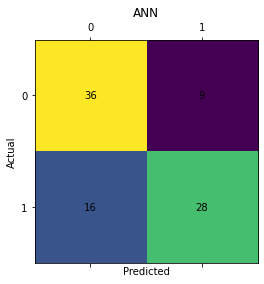

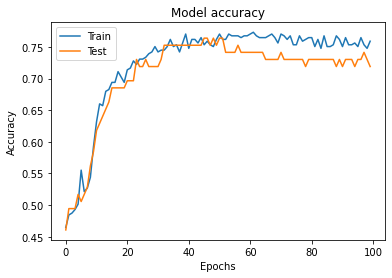

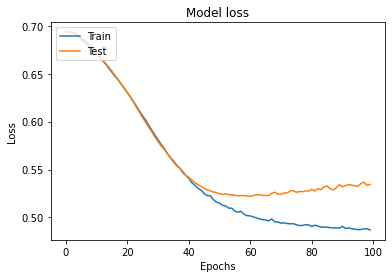

In [78]:
pr = predicter.predict(x_test)
pr_reformed = pr[:,0]
print(pr_reformed)
pr_transformed = np.zeros(len(pr))
pr_transformed[pr_reformed > 0.5] = 1
print(pr_transformed)

ann_cm = confusion_matrix(y_true=y_test, y_pred=pr_transformed)
plot_matrix('ANN', ann_cm)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Accuracy: 74.15730337078652


<Figure size 432x288 with 0 Axes>

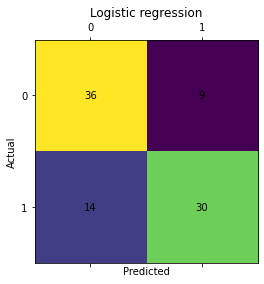

In [79]:
model = LogisticRegression(penalty = 'l2', random_state = 0)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print('Accuracy:', accuracy_score(y_test, y_pred)*100)

cm = confusion_matrix(y_test, y_pred)
plot_matrix('Logistic regression', cm)

76.40449438202246


<Figure size 432x288 with 0 Axes>

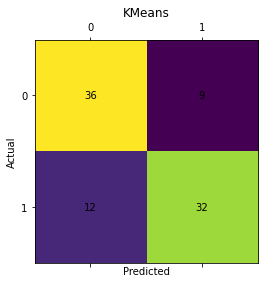

In [80]:
k_means = KMeans(n_clusters=2, max_iter=100, algorithm='auto', random_state=42, verbose=0)
k_means.fit(x_train)
k_means_predicted = k_means.predict(x_test)
print(accuracy_score(y_test, k_means_predicted)*100)
k_means_cm = confusion_matrix(y_true=y_test, y_pred = k_means_predicted)
plot_matrix('KMeans', k_means_cm)